**Task**: plan the ultimate ski holiday for 2026

**Key considerations**:
, weather patterns, prices, and the unique features

*   Visitor numbers (visitation data): perfers less visitors
*   Weather patterns (climate data): The ideal temperature for skiing was found to be close to 0 °C. (Dimitrios,2020)
*   Prices ():
*  



**Task breakdown**

1.	Data importing and cleaning
2.	Exploratory data analysis
3.	Climate data analysis
    1. Adopt a utility function for climate variables
    2. Forecast climate condition for 2026 (time series analysis?)
    3. Derive the best weeeks based on utility between 9-Jun and 15-Sep (time span used in visitor data)
    4. Limitation:
        1. adopted utility function may not reflect the true condition in Australia
        2. climate change and extreme event uncertainty may make forecasts less reliable.
4. Visitor data analysis
    1. Define factors that affect the number of visitors (weather condition, flight and accommodation prices, holiday seasons, assessibility) - use as an index of utility
    2. Research and collect data on those factors
    3. Build a regression model to predict number of visitors in 2026
    4. Derive the best location and time to visit
    5. Limitation: Economic shocks (inflation, fuel prices, global events) are hard to forecast.
5. Other data sources and factors to take into considerations?
6. Final decision: consider trade-offs and budget constraints
    1. Present final recommendation with scenario analysis (e.g., optimistic vs pessimistic climate/visitor scenarios, different demographies).
    2. Provide sensitivity analysis: how the choice changes if assumptions shift (e.g., warmer-than-usual winter).



β1(TCI modified) + β2(visitor rates) + β3(resort reputation) + β4(budget?)

Reference list:
1. Kapetanakis, D., Georgopoulou, E., Mirasgedis, S., & Sarafidis, Y. (2022). Weather Preferences for Ski Tourism: An Empirical Study on the Largest Ski Resort in Greece. Atmosphere, 13(10), 1569. https://doi.org/10.3390/atmos13101569

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv

In [3]:
with open('2025 Allianz Datathon Dataset.xlsx - Visitation Data.csv') as f:
    reader = csv.reader(f)
    visitation_data = [list(c) for c in zip(*reader)]
visitation_data = visitation_data[:-4] # filtering out empty columns of data

ex_year = visitation_data[0][1:] # year
ex_week = visitation_data[1][1:] # week
ex_daySince2014 = visitation_data[2][1:] # days since 2014

In [4]:
with open('2025 Allianz Datathon Dataset.xlsx - Climate Data.csv') as f:
    reader = csv.reader(f)
    climate_data = [list(c) for c in zip(*reader)]

In [5]:
np.array(visitation_data)

array([['Year', '2014', '2014', ..., '2024', '2024', '2024'],
       ['Week', '1', '2', ..., '13', '14', '15'],
       ['Day Since 2014', '7', '14', ..., '3611', '3618', '3625'],
       ...,
       ['Thredbo', '5535', '2090', ..., '18120', '6270', '4103'],
       ['Perisher', '7370', '2751', ..., '23908', '8244', '5336'],
       ['Charlotte Pass', '408', '151', ..., '1323', '454', '294']],
      shape=(12, 166), dtype='<U14')

# Visitation Data Cleaning

In [6]:
headers = [col[0].strip() for col in visitation_data]
rows = list(zip(*[col[1:] for col in visitation_data]))

df = pd.DataFrame(rows, columns=headers)
df.head()

df.columns = (
    df.columns.str.strip()
              .str.lower()
              .str.replace(r"[^\w\s]", "", regex=True)
              .str.replace(" ", "_")
)

for c in df.columns:
    df[c] = pd.to_numeric(df[c], errors="ignore")

for c in ["year", "week"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# datetime column
start_year = 2014
end_year = 2024
season_start_month = 6
season_start_day = 9
weeks_per_season = 15

dates = []
for year in range(start_year, end_year + 1):
    start_date = pd.Timestamp(year=year, month=season_start_month, day=season_start_day)
    # Generate weekly dates
    weekly_dates = [start_date + pd.Timedelta(days=7*i) for i in range(weeks_per_season)]
    dates.extend(weekly_dates)
# Add new datetime column
df["date"] = dates
df = df.drop(columns=["day_since_2014"])

# id columns we want to keep as identifiers
id_cols = ["year", "week", 'date']

# everything else are resorts
resort_cols = [c for c in df.columns if c not in id_cols]
from datetime import date


# reshape
df_visitation_clean = df.melt(
    id_vars=id_cols,
    value_vars=resort_cols,
    var_name="resort",
    value_name="visitors"
)

# visitors as numbers
df_visitation_clean["visitors"] = pd.to_numeric(df_visitation_clean["visitors"], errors="coerce")


C:\Users\ldown\AppData\Local\Temp\ipykernel_32732\33581285.py:15: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[c] = pd.to_numeric(df[c], errors="ignore")


## **Distance from city to Ski resorts Data**

In [7]:
import pandas as pd

resort_info = pd.DataFrame({
    "resort": [
        "thredbo",
        "perisher",
        "cabramurra",
        "mount_buller",
        "falls_creek",
        "mount_hotham",
        "mount_baw_baw"
    ],
    "state": ["NSW","NSW","NSW","VIC","VIC","VIC","VIC"],
    "distance_from_city_km": [500, 490, 510, 250, 390, 375, 120],
    "drive_time_hr": [6.0, 5.5, 6.0, 3.0, 4.5, 4.5, 2.5],
    "nearest_city": ["Sydney","Sydney","Sydney","Melbourne","Melbourne","Melbourne","Melbourne"]
})

resort_info

,resort,state,distance_from_city_km,drive_time_hr,nearest_city
0,thredbo,NSW,500,6.0,Sydney
1,perisher,NSW,490,5.5,Sydney
2,cabramurra,NSW,510,6.0,Sydney
3,mount_buller,VIC,250,3.0,Melbourne
4,falls_creek,VIC,390,4.5,Melbourne
5,mount_hotham,VIC,375,4.5,Melbourne
6,mount_baw_baw,VIC,120,2.5,Melbourne


## **Winter school holiday timeline data from 2014 to 2026**

In [8]:
import pandas as pd

# === Winter school holiday periods 2014–2026 ===
holiday_data = [
    # NSW winter holidays (July)
    {"state":"NSW","year":2014,"start":"2014-06-30","end":"2014-07-11"},
    {"state":"NSW","year":2015,"start":"2015-06-27","end":"2015-07-12"},
    {"state":"NSW","year":2016,"start":"2016-07-02","end":"2016-07-17"},
    {"state":"NSW","year":2017,"start":"2017-07-01","end":"2017-07-16"},
    {"state":"NSW","year":2018,"start":"2018-07-07","end":"2018-07-22"},
    {"state":"NSW","year":2019,"start":"2019-07-06","end":"2019-07-21"},
    {"state":"NSW","year":2020,"start":"2020-07-04","end":"2020-07-19"},
    {"state":"NSW","year":2021,"start":"2021-06-26","end":"2021-07-11"},
    {"state":"NSW","year":2022,"start":"2022-07-02","end":"2022-07-17"},
    {"state":"NSW","year":2023,"start":"2023-07-01","end":"2023-07-16"},
    {"state":"NSW","year":2024,"start":"2024-07-06","end":"2024-07-21"},
    {"state":"NSW","year":2025,"start":"2025-07-07","end":"2025-07-18"},
    {"state":"NSW","year":2026,"start":"2026-07-06","end":"2026-07-17"},

    # VIC winter holidays (June/July)
    {"state":"VIC","year":2014,"start":"2014-06-28","end":"2014-07-13"},
    {"state":"VIC","year":2015,"start":"2015-06-27","end":"2015-07-12"},
    {"state":"VIC","year":2016,"start":"2016-06-25","end":"2016-07-10"},
    {"state":"VIC","year":2017,"start":"2017-07-01","end":"2017-07-16"},
    {"state":"VIC","year":2018,"start":"2018-06-30","end":"2018-07-15"},
    {"state":"VIC","year":2019,"start":"2019-06-29","end":"2019-07-14"},
    {"state":"VIC","year":2020,"start":"2020-06-27","end":"2020-07-12"},
    {"state":"VIC","year":2021,"start":"2021-06-26","end":"2021-07-11"},
    {"state":"VIC","year":2022,"start":"2022-06-25","end":"2022-07-10"},
    {"state":"VIC","year":2023,"start":"2023-06-24","end":"2023-07-09"},
    {"state":"VIC","year":2024,"start":"2024-06-29","end":"2024-07-14"},
    {"state":"VIC","year":2025,"start":"2025-06-28","end":"2025-07-13"},
    {"state":"VIC","year":2026,"start":"2026-06-28","end":"2026-07-13"},
]

school_holidays = pd.DataFrame(holiday_data)
school_holidays["start"] = pd.to_datetime(school_holidays["start"])
school_holidays["end"]   = pd.to_datetime(school_holidays["end"])

display(school_holidays)

,state,year,start,end
0,NSW,2014,2014-06-30,2014-07-11
1,NSW,2015,2015-06-27,2015-07-12
2,NSW,2016,2016-07-02,2016-07-17
3,NSW,2017,2017-07-01,2017-07-16
4,NSW,2018,2018-07-07,2018-07-22
5,NSW,2019,2019-07-06,2019-07-21
6,NSW,2020,2020-07-04,2020-07-19
7,NSW,2021,2021-06-26,2021-07-11
8,NSW,2022,2022-07-02,2022-07-17
9,NSW,2023,2023-07-01,2023-07-16


## **Ski resort average price data**

In [9]:
import pandas as pd

resort_price_info = pd.DataFrame({
    "resort": [
        "perisher", "thredbo", "falls_creek", "mount_hotham", "mount_buller", "mount_baw_baw"
    ],
    "avg_lift_ticket_adult": [
        179,   # Perisher
        189,   # Thredbo
        220,   # Falls Creek
        220,   # Hotham
        220,   # Buller
        79     # Baw Baw
    ],
    "avg_accommodation_pp_per_night": [
        150,   # Perisher
        150,   # Thredbo
        180,   # Falls Creek
        180,   # Hotham
        180,   # Buller
        280    # Baw Baw
    ],
    "resort_entry_per_vehicle": [
        29,    # Perisher (Kosciuszko NP)
        29,    # Thredbo (Kosciuszko NP)
        64,    # Falls Creek
        64,    # Hotham
        64,    # Buller
        64     # Baw Baw
    ]
})

resort_price_info

,resort,avg_lift_ticket_adult,avg_accommodation_pp_per_night,resort_entry_per_vehicle
0,perisher,179,150,29
1,thredbo,189,150,29
2,falls_creek,220,180,64
3,mount_hotham,220,180,64
4,mount_buller,220,180,64
5,mount_baw_baw,79,280,64


## **Visitors by resort Graph**

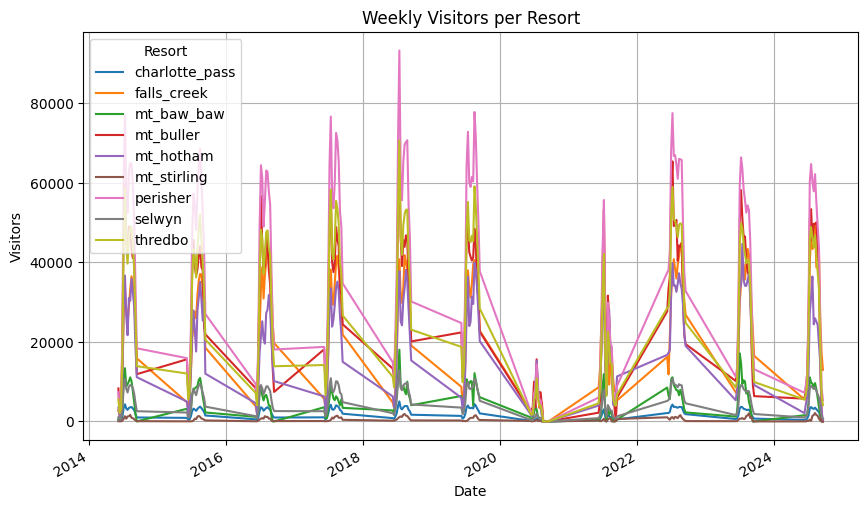

In [10]:
# Pivot so resorts are columns
pivoted = df_visitation_clean.pivot(index="date", columns="resort", values="visitors")

# Plot line graph
pivoted.plot(kind="line", figsize=(10,6))
plt.title("Weekly Visitors per Resort")
plt.xlabel("Date")
plt.ylabel("Visitors")
plt.legend(title="Resort")
plt.grid(True)
plt.show()

# Climate Data Cleaning

In [11]:
from datetime import datetime

dateTimeArr = []

for i in range(len(climate_data[0])):
    if i == 0:
        continue #skip 0 index (title)

    datetimeConversion = datetime(
        year=int(climate_data[1][i]),
        month=int(climate_data[2][i]),
        day=int(climate_data[3][i]),
    )
    dateTimeArr.append(datetimeConversion)
print(pd.DataFrame(dateTimeArr).head())
dateTimeArr.insert(0, "Datetime")
climate_data.append(dateTimeArr)
del climate_data[1:4] # remove time, month and year
df_climate = pd.DataFrame(climate_data)

           0
0 2010-01-01
1 2010-01-02
2 2010-01-03
3 2010-01-04
4 2010-01-05


In [12]:
# dataset tranposing
climate_data_T = df_climate.T.reset_index(drop=True)

# first row of dataframe as headers
climate_data_T.columns = climate_data_T.iloc[0]

# drop header row
climate_data_T = climate_data_T.drop(0).reset_index(drop=True)

# conversion to corrected datatypes
climate_data_T["Datetime"] = pd.to_datetime(climate_data_T["Datetime"], errors="coerce")
climate_data_T["Maximum temperature (Degree C)"] = pd.to_numeric(climate_data_T["Maximum temperature (Degree C)"], errors="coerce")
climate_data_T["Minimum temperature (Degree C)"] = pd.to_numeric(climate_data_T["Minimum temperature (Degree C)"], errors="coerce")
climate_data_T["Rainfall amount (millimetres)"] = pd.to_numeric(climate_data_T["Rainfall amount (millimetres)"], errors="coerce")
climate_data_T["Bureau of Meteorology station number"] = pd.to_numeric(climate_data_T["Bureau of Meteorology station number"], errors="coerce")

# convert any that failed to parse correctly in transition to datetime
climate_data_T = climate_data_T.dropna(subset=["Datetime"])

# drop any rows with all values missing
df_clean = climate_data_T.dropna(subset=[
    "Maximum temperature (Degree C)",
    "Minimum temperature (Degree C)",
    "Rainfall amount (millimetres)"
], how="all")

# dropping for any missing values
df_climate_clean = df_clean.dropna()

df_climate_clean

,Bureau of Meteorology station number,Maximum temperature (Degree C),Minimum temperature (Degree C),Rainfall amount (millimetres),Datetime
145,71075,3.0,2.1,34.6,2010-05-26
146,71075,8.5,-1.7,2.2,2010-05-27
147,71075,7.1,-0.3,0.2,2010-05-28
148,71075,6.0,2.5,8.4,2010-05-29
149,71075,4.7,-0.2,52.2,2010-05-30
...,...,...,...,...,...
39808,72161,3.0,-2.7,4.2,2025-07-24
39809,72161,6.0,-2.4,0.2,2025-07-25
39810,72161,2.7,0.0,10.2,2025-07-26
39811,72161,2.5,1.3,15.6,2025-07-27


## Outlier Removal (Rainfall)

In [13]:
# 1.5 inner quartile range code
# computing IQR
Q1 = df_climate_clean['Rainfall amount (millimetres)'].quantile(0.25)
Q3 = df_climate_clean['Rainfall amount (millimetres)'].quantile(0.75)
IQR = Q3 - Q1

# Filtering Values between Q1-1.5IQR and Q3+1.5IQR
filtered_ml = df_climate_clean.query('(@Q1 - 1.5 * @IQR) <= `Rainfall amount (millimetres)` <= (@Q3 + 1.5 * @IQR)')
# Ploting the result to check the difference
# df.join(filtered, rsuffix='_filtered').boxplot()
print(len(df_climate_clean["Rainfall amount (millimetres)"]) - len(filtered_ml)) # ml outliers


# 1.5 inner quartile range code
# computing IQR
Q1 = df_climate_clean['Minimum temperature (Degree C)'].quantile(0.25)
Q3 = df_climate_clean['Minimum temperature (Degree C)'].quantile(0.75)
IQR = Q3 - Q1

# Filtering Values between Q1-1.5IQR and Q3+1.5IQR
filtered_minTemp = df_climate_clean.query('(@Q1 - 1.5 * @IQR) <= `Minimum temperature (Degree C)` <= (@Q3 + 1.5 * @IQR)')

print(len(df_climate_clean["Minimum temperature (Degree C)"]) - len(filtered_minTemp)) # min temp outliers

5718
30


In [14]:
# df_climate_clean = filtered_ml
df_climate_clean = df_climate_clean.dropna()

In [15]:
df_climate_clean # filtered rainfall outlier

,Bureau of Meteorology station number,Maximum temperature (Degree C),Minimum temperature (Degree C),Rainfall amount (millimetres),Datetime
145,71075,3.0,2.1,34.6,2010-05-26
146,71075,8.5,-1.7,2.2,2010-05-27
147,71075,7.1,-0.3,0.2,2010-05-28
148,71075,6.0,2.5,8.4,2010-05-29
149,71075,4.7,-0.2,52.2,2010-05-30
...,...,...,...,...,...
39808,72161,3.0,-2.7,4.2,2025-07-24
39809,72161,6.0,-2.4,0.2,2025-07-25
39810,72161,2.7,0.0,10.2,2025-07-26
39811,72161,2.5,1.3,15.6,2025-07-27


This displays a large amount of outliers within the minimum rainfall

## Station Filtering

In [16]:
# state, VIC and NSW datasets
df_climate_clean.head()

,Bureau of Meteorology station number,Maximum temperature (Degree C),Minimum temperature (Degree C),Rainfall amount (millimetres),Datetime
145,71075,3.0,2.1,34.6,2010-05-26
146,71075,8.5,-1.7,2.2,2010-05-27
147,71075,7.1,-0.3,0.2,2010-05-28
148,71075,6.0,2.5,8.4,2010-05-29
149,71075,4.7,-0.2,52.2,2010-05-30


In [17]:
# Constructing a set of all unique values of the stations
station_numbers = df_climate_clean["Bureau of Meteorology station number"]
station_unique = set()
for _ in station_numbers:
  if _ not in station_unique:
    station_unique.add(_)
station_unique

{71032, 71075, 72161, 83024, 83084, 83085, 85291}

In [18]:
# constructing isolated dataframes based on the station vlaues
df_stations = {}
for station_number in station_unique:
  df_station = df_climate_clean[df_climate_clean["Bureau of Meteorology station number"] == station_number]
  df_stations[f"{station_number}"] = df_station
  # df_stations.append(df_station)

# print each dataframe
for df in df_stations.values():
  display(df)

,Bureau of Meteorology station number,Maximum temperature (Degree C),Minimum temperature (Degree C),Rainfall amount (millimetres),Datetime
34125,72161,20.9,12.2,2.6,2010-01-01
34126,72161,17.8,12.6,11.4,2010-01-02
34127,72161,18.9,8.5,0.6,2010-01-03
34128,72161,20.5,7.4,0.0,2010-01-04
34129,72161,20.7,11.7,0.0,2010-01-05
...,...,...,...,...,...
39808,72161,3.0,-2.7,4.2,2025-07-24
39809,72161,6.0,-2.4,0.2,2025-07-25
39810,72161,2.7,0.0,10.2,2025-07-26
39811,72161,2.5,1.3,15.6,2025-07-27


,Bureau of Meteorology station number,Maximum temperature (Degree C),Minimum temperature (Degree C),Rainfall amount (millimetres),Datetime
145,71075,3.0,2.1,34.6,2010-05-26
146,71075,8.5,-1.7,2.2,2010-05-27
147,71075,7.1,-0.3,0.2,2010-05-28
148,71075,6.0,2.5,8.4,2010-05-29
149,71075,4.7,-0.2,52.2,2010-05-30
...,...,...,...,...,...
5683,71075,-0.7,-4.7,6.0,2025-07-24
5684,71075,5.8,-9.2,0.0,2025-07-25
5685,71075,1.4,-3.2,8.8,2025-07-26
5686,71075,1.4,0.1,36.4,2025-07-27


,Bureau of Meteorology station number,Maximum temperature (Degree C),Minimum temperature (Degree C),Rainfall amount (millimetres),Datetime
28437,85291,17.6,10.7,21.2,2010-01-01
28438,85291,8.7,7.4,12.6,2010-01-02
28439,85291,10.5,0.7,3.6,2010-01-03
28440,85291,17.1,2.0,0.0,2010-01-04
28441,85291,18.5,10.5,0.0,2010-01-05
...,...,...,...,...,...
34120,85291,1.5,-3.5,3.4,2025-07-24
34121,85291,3.9,-1.2,0.0,2025-07-25
34122,85291,1.8,-1.3,0.2,2025-07-26
34123,85291,1.6,0.3,6.8,2025-07-27


,Bureau of Meteorology station number,Maximum temperature (Degree C),Minimum temperature (Degree C),Rainfall amount (millimetres),Datetime
17061,83084,14.5,10.3,131.4,2010-01-01
17062,83084,15.6,9.4,50.6,2010-01-02
17063,83084,15.6,3.1,0.2,2010-01-03
17064,83084,15.4,4.7,0.0,2010-01-04
17065,83084,19.7,8.7,0.0,2010-01-05
...,...,...,...,...,...
22744,83084,-0.8,-4.7,2.0,2025-07-24
22745,83084,4.5,-4.7,4.6,2025-07-25
22746,83084,0.6,-2.9,3.2,2025-07-26
22747,83084,-0.1,-0.8,38.4,2025-07-27


,Bureau of Meteorology station number,Maximum temperature (Degree C),Minimum temperature (Degree C),Rainfall amount (millimetres),Datetime
22749,83085,13.7,9.1,65.4,2010-01-01
22750,83085,14.4,9.2,38.2,2010-01-02
22751,83085,13.9,4.6,0.4,2010-01-03
22752,83085,14.1,4.2,0.2,2010-01-04
22753,83085,17.7,7.7,0.0,2010-01-05
...,...,...,...,...,...
28432,83085,-1.7,-4.8,0.0,2025-07-24
28433,83085,1.5,-5.2,0.0,2025-07-25
28434,83085,0.2,-3.7,2.0,2025-07-26
28435,83085,-0.4,-1.4,41.6,2025-07-27


,Bureau of Meteorology station number,Maximum temperature (Degree C),Minimum temperature (Degree C),Rainfall amount (millimetres),Datetime
11373,83024,16.3,10.3,22.2,2010-01-01
11374,83024,13.0,10.4,40.6,2010-01-02
11375,83024,13.2,1.8,0.6,2010-01-03
11376,83024,16.7,7.8,0.0,2010-01-04
11377,83024,19.2,9.8,0.0,2010-01-05
...,...,...,...,...,...
17056,83024,-0.9,-4.1,1.8,2025-07-24
17057,83024,0.0,-4.5,0.4,2025-07-25
17058,83024,0.7,-2.9,3.4,2025-07-26
17059,83024,0.0,-0.8,10.0,2025-07-27


,Bureau of Meteorology station number,Maximum temperature (Degree C),Minimum temperature (Degree C),Rainfall amount (millimetres),Datetime
5688,71032,17.6,9.4,47.2,2010-01-01
5689,71032,13.8,9.3,29.2,2010-01-02
5690,71032,14.3,6.3,0.0,2010-01-03
5691,71032,14.9,5.1,0.0,2010-01-04
5692,71032,17.7,10.4,0.0,2010-01-05
...,...,...,...,...,...
11367,71032,1.5,-6.1,0.0,2025-07-20
11368,71032,2.7,-5.9,0.0,2025-07-21
11369,71032,2.6,-2.0,1.2,2025-07-22
11370,71032,-3.7,-5.1,24.2,2025-07-23


In [19]:
df_climate_loc = {}
for key, df in df_stations.items():
  if key == "71032":
    df_climate_loc["Thredbo"] = df
  elif key == "71075":
    df_climate_loc["Perisher"] = df
  elif key == "83084":
    df_climate_loc["Falls Creek"] = df
  elif key == "83024":
    df_climate_loc["Mount Buller"] = df
  elif key == "83085":
    df_climate_loc["Mount Hotham"] = df
  elif key == "85291":
    df_climate_loc["Mount Baw Baw"] = df
# as mount stirling is close to mount buller
df_climate_loc["Mount Stirling"] = df_climate_loc["Mount Buller"]
# charlote pass has no weather station => take equidistant avg of threbdo and perisher
# df_climate_loc["Charlote Pass"] = (df_climate_loc["Thredbo"] + df_climate_loc["Perisher"]) / 2

## Graphs & Forecast Modelling



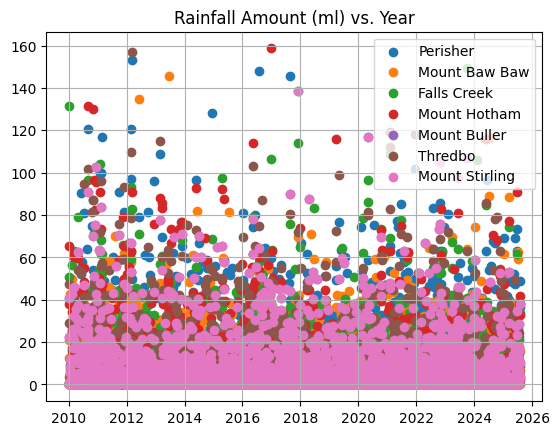

In [44]:
for key, df in df_climate_loc.items():
  plt.scatter(df["Datetime"], df["Rainfall amount (millimetres)"], label = f"{key}")
plt.title("Rainfall Amount (ml) vs. Year")
plt.legend()
plt.grid()
plt.show()


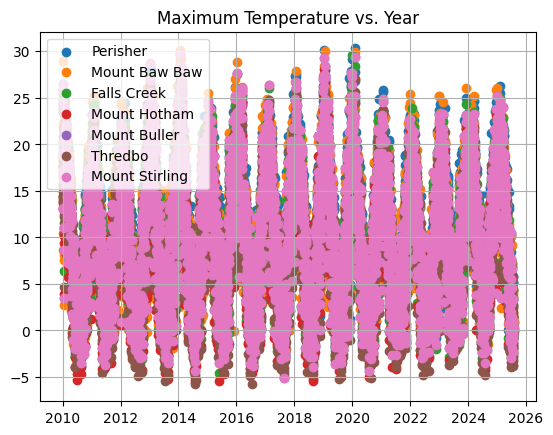

In [45]:
for key, df in df_climate_loc.items():
  plt.scatter(df["Datetime"], df["Maximum temperature (Degree C)"], label = f"{key}")
plt.title("Maximum Temperature vs. Year")
plt.legend()
plt.grid()
plt.show()

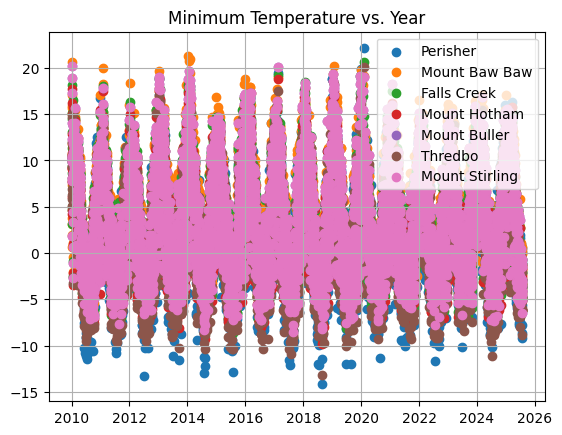

In [46]:
for key, df in df_climate_loc.items():
  plt.scatter(df["Datetime"], df["Minimum temperature (Degree C)"], label = f"{key}")
plt.title("Minimum Temperature vs. Year")
plt.legend()
plt.grid()
plt.show()

Location Mapping and Creating more Effective Visualizations

In [23]:
for key, df in df_climate_loc.items():
  print(np.mean(df["Minimum temperature (Degree C)"]))


1.2933689445570087
3.0731139337952276
2.714343395500865
2.2728360760846336
3.1272084164701615
1.3621903520208605
3.1272084164701615


In [24]:
for key, df in df_climate_loc.items():
  print(np.mean(df["Maximum temperature (Degree C)"]))

10.948111991158592
9.458121632024634
9.284464526052682
8.449198546698012
9.574986395791765
8.72687651331719
9.574986395791765


In [25]:
for key, df in df_climate_loc.items():
  print(np.mean(df["Rainfall amount (millimetres)"]))

6.0722048259347945
5.122170900692841
4.4907133243607
4.542423594785211
4.5072011608924365
4.1935928478301365
4.5072011608924365


### Heatmap & Geographical Data

Reshaping the dataframe to have dates as the index, resorts as columns, and visitors as values using the pivot method.



In [26]:
pivoted_visitation = df_visitation_clean.pivot(index="date", columns="resort", values="visitors")
display(pivoted_visitation.head())

resort,charlotte_pass,falls_creek,mt_baw_baw,mt_buller,mt_hotham,mt_stirling,perisher,selwyn,thredbo
date,,,,,,,,,
2014-06-09,408,2790,555,8296,3483,60,7370,1041,5535
2014-06-16,151,1425,804,1987,1253,42,2751,383,2090
2014-06-23,230,2101,993,2413,2992,30,4255,597,3216
2014-06-30,1134,9544,2976,18831,9680,165,20265,2877,15497
2014-07-07,3403,26211,11112,49217,29628,645,61339,8588,46546


Creating a heatmap to map the visitation values


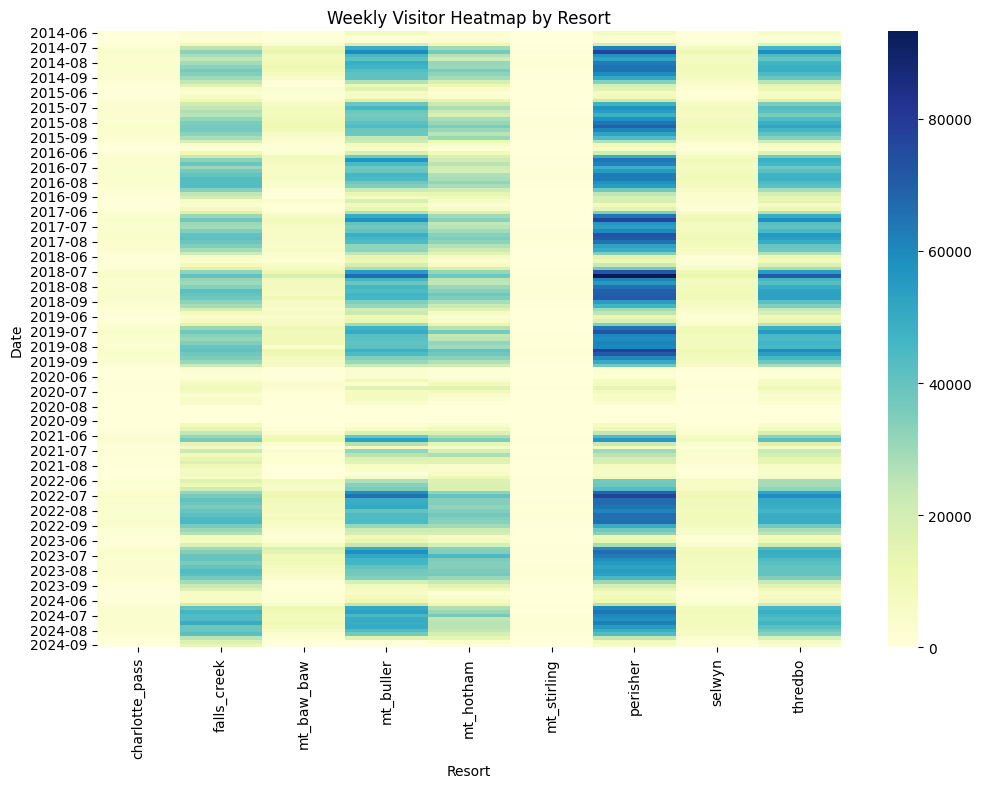

In [27]:
import seaborn as sns

# Format the date to display only year and month
pivoted_visitation.index = pivoted_visitation.index.strftime('%Y-%m')

plt.figure(figsize=(12, 8))
sns.heatmap(pivoted_visitation, cmap="YlGnBu")
plt.title("Weekly Visitor Heatmap by Resort")
plt.xlabel("Resort")
plt.ylabel("Date")
plt.show()

## Prepare data for location-based map


Grouping the visitation data by resort and calculate the mean visitors, then merge with resort information.



In [28]:
avg_visitors_per_resort = df_visitation_clean.groupby('resort')['visitors'].mean().reset_index()
merged_resort_data = pd.merge(avg_visitors_per_resort, resort_info, on='resort', how='left')
display(merged_resort_data.head())

,resort,visitors,state,distance_from_city_km,drive_time_hr,nearest_city
0,charlotte_pass,2181.812121,NaN,NaN,NaN,NaN
1,falls_creek,24027.145455,VIC,390.0,4.5,Melbourne
2,mt_baw_baw,5373.648485,NaN,NaN,NaN,NaN
3,mt_buller,29349.296970,NaN,NaN,NaN,NaN
4,mt_hotham,20110.333333,NaN,NaN,NaN,NaN


## Create location-based map

### Subtask:
Generate a map visualizing visitor numbers at each resort location.


**Reasoning**:
Import folium and create a base map, then iterate through the merged_resort_data to add markers for each resort with available location data and display the map.



In [29]:
import folium

# Approximate center of the ski resorts in Australia
australia_center = [-36.5, 147.0]
m = folium.Map(location=australia_center, zoom_start=8)

# Define a dictionary to store resort coordinates (latitude, longitude)
resort_coords = {
    "thredbo": [-36.5000, 148.3000],
    "perisher": [-36.4000, 148.4167],
    "falls_creek": [-36.7167, 147.2833],
    "mount_hotham": [-36.9667, 147.1500],
    "mount_buller": [-37.1500, 146.4500],
    "mount_baw_baw": [-37.9333, 146.2667],
    "charlotte_pass": [-36.4269, 148.3425],
    "mt_stirling": [-37.1486, 146.5372],
    "selwyn": [-35.5167, 148.2667] # Approximate location
}

for index, row in merged_resort_data.iterrows():
    resort_name = row['resort']
    visitors = row['visitors']

    if resort_name in resort_coords:
        coords = resort_coords[resort_name]
        folium.Marker(
            location=coords,
            popup=f"{resort_name.replace('_', ' ').title()}<br>Average Visitors: {visitors:.0f}"
        ).add_to(m)

display(m)

ModuleNotFoundError: No module named 'folium'

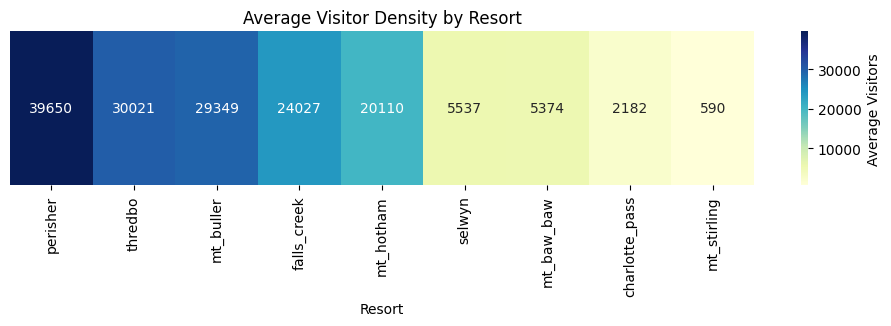

In [ ]:
# Calculate average visitors per resort
avg_visitors_per_resort = df_visitation_clean.groupby('resort')['visitors'].mean().reset_index()

# Sort by average visitors for better visualization
avg_visitors_per_resort = avg_visitors_per_resort.sort_values('visitors', ascending=False)

# Reshape for heatmap
avg_visitors_heatmap_data = avg_visitors_per_resort.set_index('resort').T

plt.figure(figsize=(12, 2)) # Adjust figure size for a single row heatmap
sns.heatmap(avg_visitors_heatmap_data, cmap="YlGnBu", annot=True, fmt=".0f", cbar_kws={'label': 'Average Visitors'})
plt.title("Average Visitor Density by Resort")
plt.xlabel("Resort")
plt.ylabel("") # No need for a y-label in this case
plt.yticks([]) # Remove y-axis ticks
plt.show()

### Skier Experience Metric Factor

In [30]:
for key, df in df_climate_loc.items():
  print(np.mean(df["Maximum temperature (Degree C)"]))

10.948111991158592
9.458121632024634
9.284464526052682
8.449198546698012
9.574986395791765
8.72687651331719
9.574986395791765


In [31]:
for key, df in df_climate_loc.items():
  print(np.mean(df["Minimum temperature (Degree C)"]))

1.2933689445570087
3.0731139337952276
2.714343395500865
2.2728360760846336
3.1272084164701615
1.3621903520208605
3.1272084164701615


In [32]:
for key, df in df_climate_loc.items():
  print(np.mean(df["Rainfall amount (millimetres)"]))

6.0722048259347945
5.122170900692841
4.4907133243607
4.542423594785211
4.5072011608924365
4.1935928478301365
4.5072011608924365


In [33]:
skierExpFunc = lambda avgMin, avgMax, totalPrec: avgMin * -0.55574/100 + avgMax * -0.55574/100 + totalPrec * -0.02137/100

In [34]:
# Testing function
skierExpFunc(10.948111991158592, 1.2933689445570087, 32966.0)

-7.112865006152147

In [35]:
# saving the data
skierExpArr = []
for key, df in df_climate_loc.items():
  skiExpFactor = skierExpFunc(np.mean(df["Minimum temperature (Degree C)"]), np.mean(df["Maximum temperature (Degree C)"]), np.mean(df["Rainfall amount (millimetres)"]))
  skierExpArr.append(skiExpFactor)
skierExpArr

[np.float64(-0.06932843632344815),
 np.float64(-0.07073569645496536),
 np.float64(-0.06764184058065756),
 np.float64(-0.06055735113485787),
 np.float64(-0.07155436633774713),
 np.float64(-0.05696515098901099),
 np.float64(-0.07155436633774713)]

In [36]:
max(skierExpArr)

np.float64(-0.05696515098901099)

### Assuming that the daily data is averaged
Transitioning the factor to combine the min, max and rainfall data to the metric factor above

In [47]:
# saving the data
skierExpArr = []
for key, df in df_climate_loc.items():
  skiExpFactor = skierExpFunc(df["Minimum temperature (Degree C)"], df["Maximum temperature (Degree C)"]), np.mean(df["Rainfall amount (millimetres)"])
  skierExpArr.append(skiExpFactor)
skierExpArr

TypeError: <lambda>() missing 1 required positional argument: 'totalPrec'

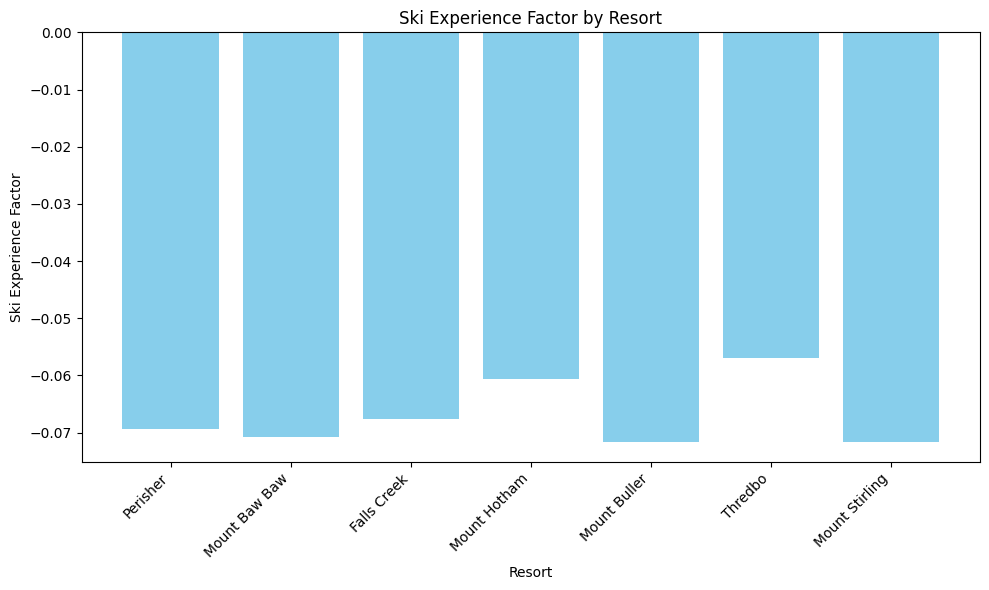

,Resort,Ski Experience Factor
0,Perisher,-0.069328
1,Mount Baw Baw,-0.070736
2,Falls Creek,-0.067642
3,Mount Hotham,-0.060557
4,Mount Buller,-0.071554
5,Thredbo,-0.056965
6,Mount Stirling,-0.071554


In [48]:
df_metric_loc = {}
for key, df in df_climate_loc.items():
  # Calculate the mean of the relevant columns for each resort
  avg_min_temp = df['Minimum temperature (Degree C)'].mean()
  avg_max_temp = df['Maximum temperature (Degree C)'].mean()
  avg_rainfall = df['Rainfall amount (millimetres)'].mean()

  # Calculate the ski experience factor using the defined function
  ski_exp_factor = skierExpFunc(avg_min_temp, avg_max_temp, avg_rainfall)

  # Store the ski experience factor in the new dictionary
  df_metric_loc[key] = ski_exp_factor

# Convert the dictionary to a DataFrame for easier plotting
df_metric_loc_df = pd.DataFrame(list(df_metric_loc.items()), columns=['Resort', 'Ski Experience Factor'])

# Plot the ski experience factors
plt.figure(figsize=(10, 6))
plt.bar(df_metric_loc_df['Resort'], df_metric_loc_df['Ski Experience Factor'], color='skyblue')
plt.xlabel('Resort')
plt.ylabel('Ski Experience Factor')
plt.title('Ski Experience Factor by Resort')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

display(df_metric_loc_df)

In [39]:
df_metric_loc = {}
for key, df in df_climate_loc.items():
  # Apply skierExpFunc to daily data to create a new 'Ski Experience Factor' column
  # Assuming skierExpFunc takes min_temp, max_temp, rainfall in that order
  df_metric_loc[key] = df.copy() # Create a copy to avoid modifying the original dataframe
  df_metric_loc[key]['Ski Experience Factor'] = df_metric_loc[key].apply(
      lambda row: skierExpFunc(
          row['Minimum temperature (Degree C)'],
          row['Maximum temperature (Degree C)'],
          row['Rainfall amount (millimetres)']
      ),
      axis=1
  )

# Display the first few rows of the modified dataframe for one resort as an example
if df_metric_loc:
  first_resort_key = list(df_metric_loc.keys())[0]
  display(df_metric_loc[first_resort_key].head())

,Bureau of Meteorology station number,Maximum temperature (Degree C),Minimum temperature (Degree C),Rainfall amount (millimetres),Datetime,Ski Experience Factor
145,71075,3.0,2.1,34.6,2010-05-26,-0.035737
146,71075,8.5,-1.7,2.2,2010-05-27,-0.038260
147,71075,7.1,-0.3,0.2,2010-05-28,-0.037833
148,71075,6.0,2.5,8.4,2010-05-29,-0.049033
149,71075,4.7,-0.2,52.2,2010-05-30,-0.036163


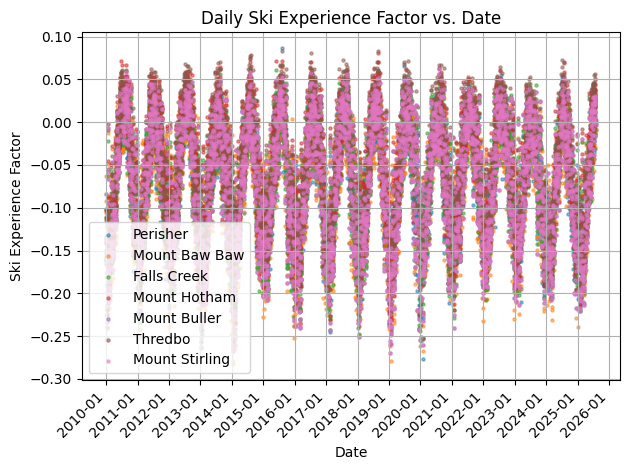

In [40]:
import matplotlib.dates as mdates

for key, df in df_metric_loc.items():
  plt.scatter(
      df["Datetime"],
      df["Ski Experience Factor"],
      label = f"{key}",
      s=5, # Reduce marker size
      alpha=0.5 # Add transparency
  )

plt.title("Daily Ski Experience Factor vs. Date")
plt.xlabel("Date")
plt.ylabel("Ski Experience Factor")
plt.legend()
plt.grid(True) # Add a grid for better readability

# Format the x-axis to show year and month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator()) # Show ticks for each year
plt.xticks(rotation=45, ha='right') # Rotate labels for better visibility


plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

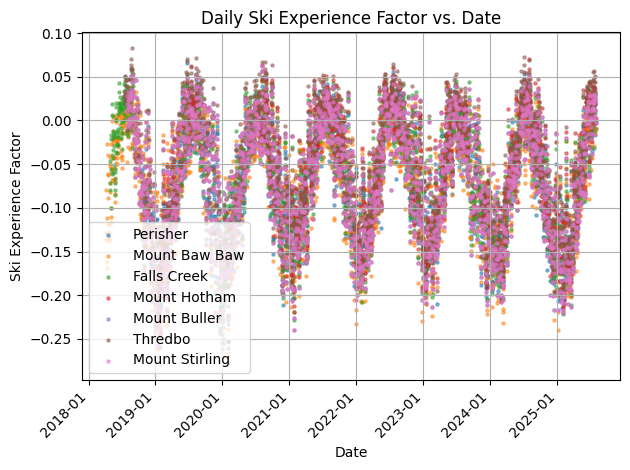

In [41]:
import matplotlib.dates as mdates

for key, df in df_metric_loc.items():
  plt.scatter(
      df["Datetime"][3000:],
      df["Ski Experience Factor"][3000:],
      label = f"{key}",
      s=5, # Reduce marker size
      alpha=0.5 # Add transparency
  )

plt.title("Daily Ski Experience Factor vs. Date")
plt.xlabel("Date")
plt.ylabel("Ski Experience Factor")
plt.legend()
plt.grid(True) # Add a grid for better readability

# Format the x-axis to show year and month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator()) # Show ticks for each year
plt.xticks(rotation=45, ha='right') # Rotate labels for better visibility


plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

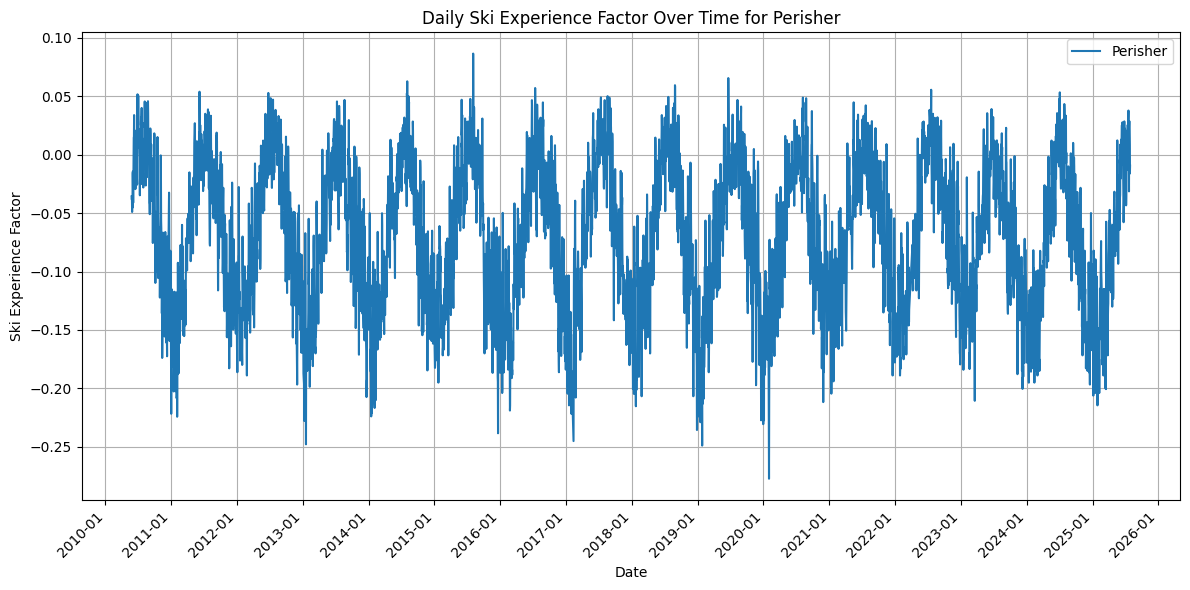

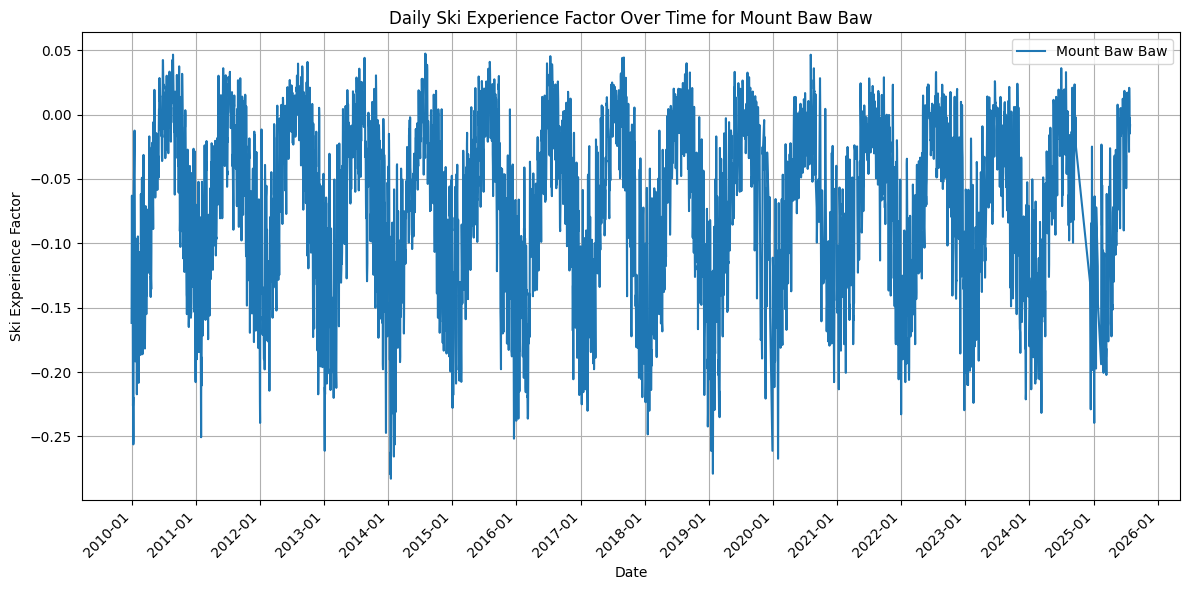

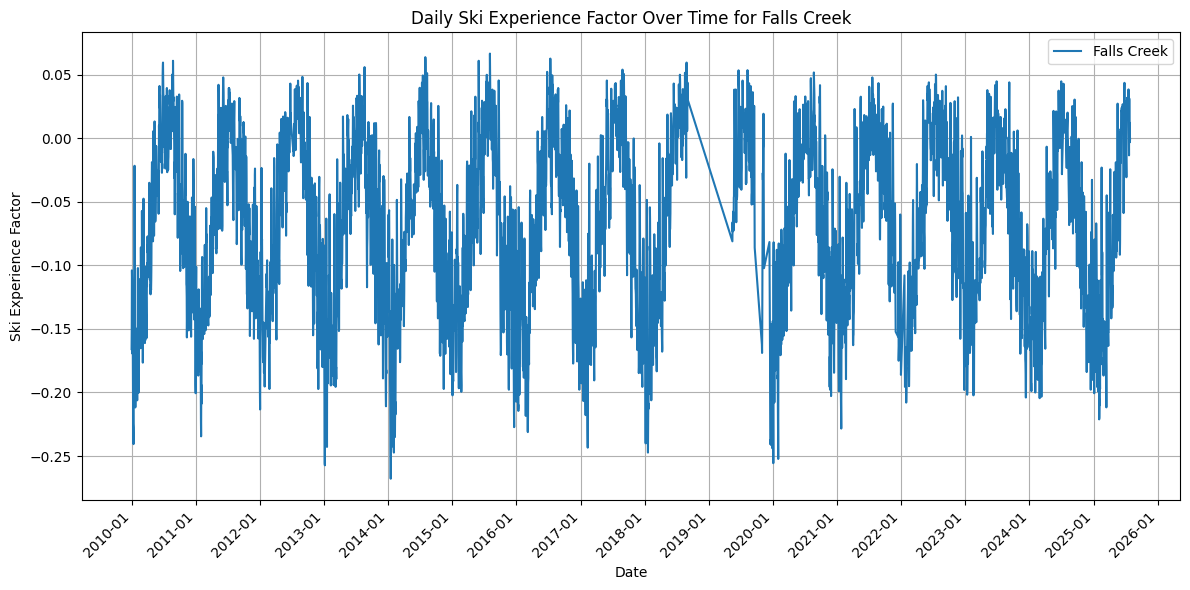

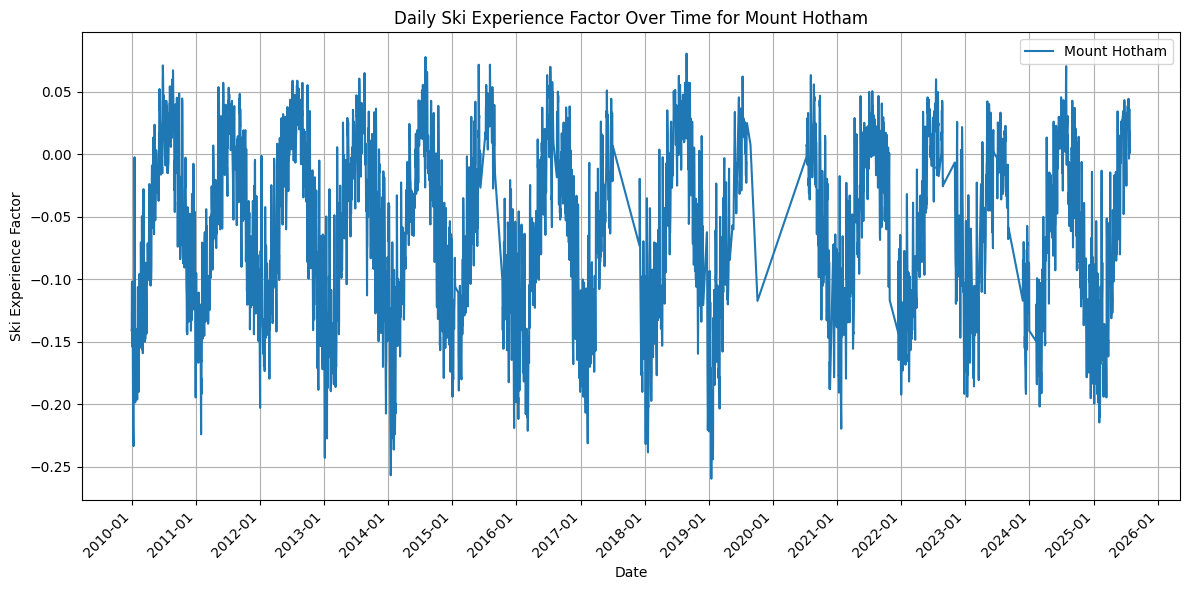

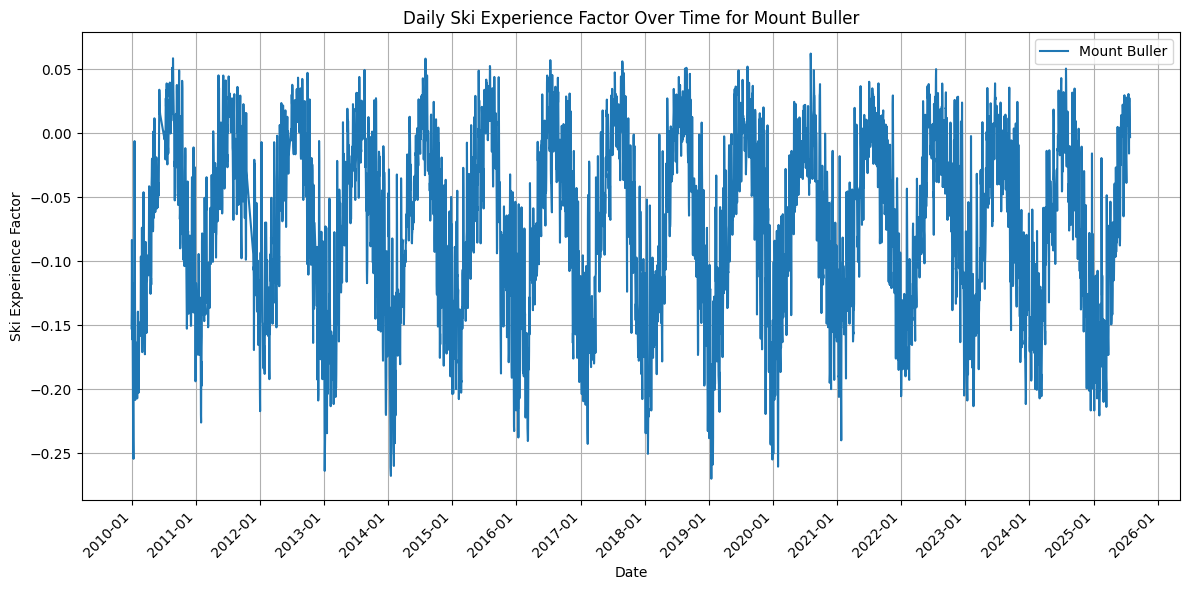

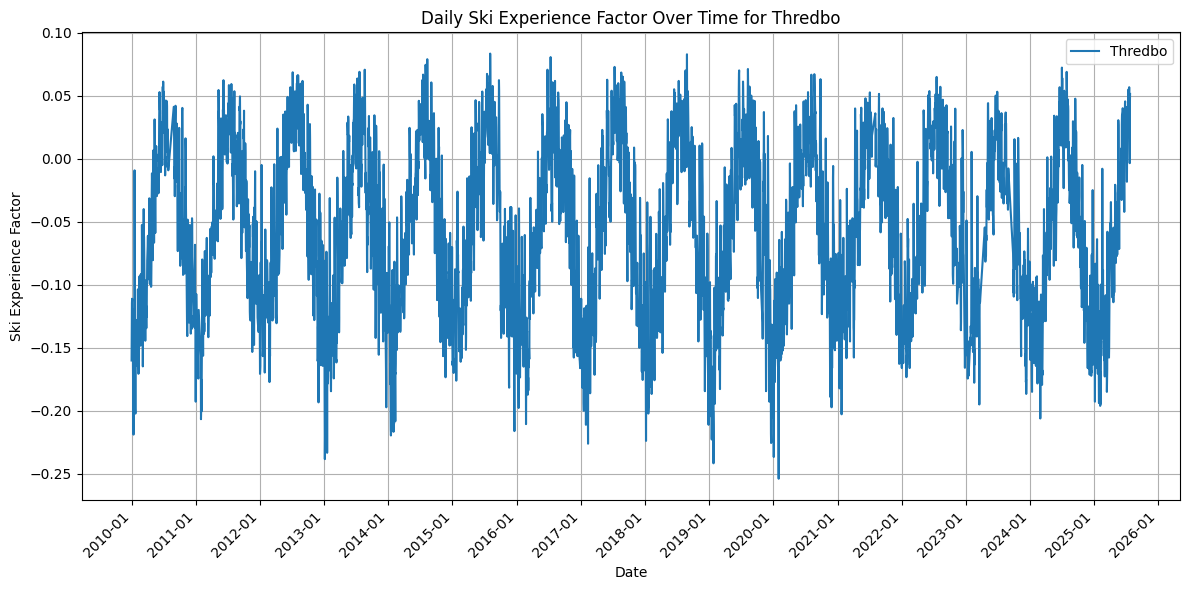

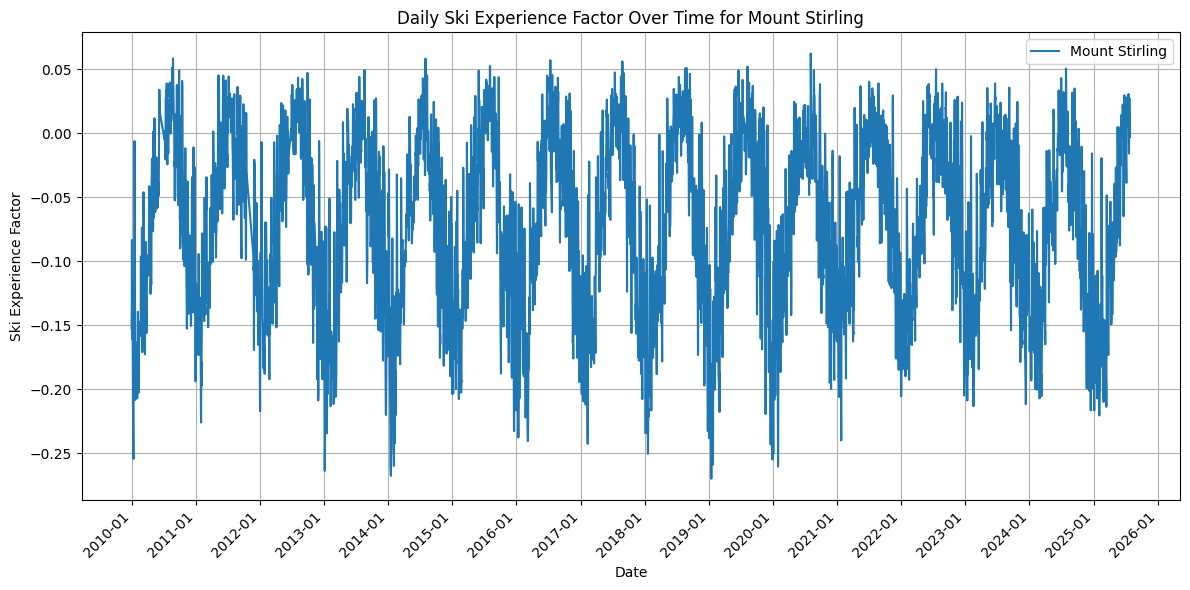

In [42]:
import matplotlib.dates as mdates

for key, df in df_metric_loc.items():
    plt.figure(figsize=(12, 6)) # Create a new figure for each resort
    plt.plot(
        df["Datetime"],
        df["Ski Experience Factor"],
        label = f"{key}"
    )

    plt.title(f"Daily Ski Experience Factor Over Time for {key}")
    plt.xlabel("Date")
    plt.ylabel("Ski Experience Factor")
    plt.legend()
    plt.grid(True) # Add a grid for better readability

    # Format the x-axis to show year and month
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator()) # Show ticks for each year
    plt.xticks(rotation=45, ha='right') # Rotate labels for better visibility

    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.show()